In [1]:
import random 
import csv
import os
import time
import matplotlib.pyplot as plt

In [4]:
class Store:
    def __init__(self, store_id, store_name, branch, estimated_bags, rating, longitude, latitude):
        # private attributes
        self._store_id = store_id
        self._store_name = store_name
        self._branch = branch 
        self._rating = rating 
        self._price_per_bag = None 
        self._estimated_bags = estimated_bags # average_bags_at_9AM
        self._actual_bags = None # actual bags at night
        self._bags_reserved = 0 
        self._bags_canceled = 0 
        self._bags_sold = 0 
        self._longitude = longitude
        self._latitude = latitude

    # setters
    def set_price_per_bag(self, price):
        self._price_per_bag = price 

    def set_actual_bags(self, count):
        self._actual_bags = count 

    def set_bags_sold(self, sold):
        self._bags_sold = sold

    def set_bags_canceled(self, canceled):
        self._bags_canceled = canceled


    # getters
    def get_store_id(self):
        return self._store_id
    
    def get_store_name(self):
        return self._store_name
    
    def get_branch(self):
        return self._branch
    
    def get_price_per_bag(self):
        return self._price_per_bag 

    def get_estimated_bags(self):
        return self._estimated_bags 

    def get_actual_bags(self):
        return self._actual_bags 
    
    def get_unreserved_bags(self):
        unreserved_bags = (self._estimated_bags - self._bags_reserved)
        if unreserved_bags > 0:
            return unreserved_bags
        else:
            return 0
        
    def get_reserved_bags(self):
        return self._bags_reserved
    
    def get_canceled_bags(self):
        return self._bags_canceled
    
    def get_sold_bags(self):
        return self._bags_sold
    
    def get_rating(self):
        return self._rating
    
    def get_location(self):
        return {self._longitude, self._latitude}

    
    def reserve_bag(self):
        self._bags_reserved += 1

    def cancel_bag(self):
        self._bags_canceled += 1

    def sell_bag(self):
        self._bags_sold += 1

    def reset(self): #reset all counters for the next day
        self._bags_reserved = 0
        self._bags_sold = 0
        self._bags_canceled = 0
        self._actual_bags = None


In [5]:
class Customer:
    def __init__(self, customer_id, valuations, longitude, latitude):
        self._customer_id = customer_id
        self._valuations = valuations
        self._longitude = longitude
        self._latitude = latitude
        self._reserved_store_ID = None # store the store at which the customer reserved a bag from for future purposes (and printing purposes too)


    def get_customer_id(self):
        return self._customer_id
    
    def get_valuation(self, store_id):
        return self._valuations[store_id]
    
    def get_location(self):
        return {self._longitude, self._latitude}
    
    def get_reserved_store(self):
        return self._reserved_store_ID
    
    def reserve(self, store_id):
        self._reserved_store_ID = store_id

    def reset(self): # reset some data for the next day (rn its just the reserved store id actually lol)
        self._reserved_store_ID = None
    

In [6]:
class Marketplace:
    def __init__(self, n=10, stores=None, customers=None):
        # how many stores we show to each customer
        self._n = n

        # list of Store objects in the system
        self._stores = stores if stores else []

        # list of Customer objects in the system
        self._customers = customers if customers else []

        self.algorithm1 = Algorithm1()
        self.algorithm2 = Algorithm2()
        self.algorithm3 = Algorithm3()
        self.algorithm4 = Algorithm4()
        self.final_algorithm = FinalAlgorithm()

        # for each store: how many times it was shown to customers
        # used later for fairness (exposure) KPI
        self._exposure_counts = {}
        for store in self._stores:
            self._exposure_counts[store.get_store_id()] = 0

    def add_store(self, store):
        # add a new store and start its exposure count at 0
        self._stores.append(store)
        self._exposure_counts[store.get_store_id()] = 0

    def add_customer(self, customer):
        # add a new customer to the system
        self._customers.append(customer)

    def get_stores(self):
        return self._stores

    def get_customers(self):
        return self._customers

    def set_stores(self, stores):
        # replace all stores (used when we load from dataset)
        self._stores = stores
        # reset exposure counts for the new list of stores
        self._exposure_counts = {store.get_store_id(): 0 for store in self._stores}

    def set_customers(self, customers):
        self._customers = customers

    def select(self, customer):
        """
        main selection function used in milestone 2
        we use a greedy baseline: show top-N stores by rating that still have bags
        """
        selected_stores = self._greedy_baseline(self._stores, self._n) # !!!!!!! CHANGE THIS HEEREEEEE to change algorithm

        # we record that these stores were shown to this customer
        self._record_exposure(selected_stores)

        return selected_stores

    def _greedy_baseline(self, stores, N):
        """
        choose at most N stores:
        1) they must still have unreserved bags
        2) we sort them by rating (highest first)
        """
        available_stores = []

        for store in stores:
            # get_unreserved_bags() = how many bags are still free to sell
            if store.get_unreserved_bags() > 0:
                available_stores.append(store)

        # sort by rating in descending order
        available_stores.sort(key=lambda s: s.get_rating(), reverse=True)

        # return only the first N stores (or fewer if list is smaller)
        return available_stores[:N]

    def _record_exposure(self, selected_stores):
        # every time a store is shown, we increase its exposure count by 1
        for store in selected_stores:
            sid = store.get_store_id()
            if sid not in self._exposure_counts:
                self._exposure_counts[sid] = 0
            self._exposure_counts[sid] += 1

    def compute_kpis(self):
        """
        compute KPIs for one simulation run (one "day")
        we aggregate over all stores and all customers
        """
        total_reserved = 0
        total_canceled = 0
        total_actual_bags = 0
        total_sold_bags = 0

        total_revenue = 0.0
        max_possible_revenue = 0.0

        for store in self._stores:
            price = store.get_price_per_bag()
            if price is None:
                price = 0.0

            # estimated bags from 9AM (given in the dataset)
            estimated = store.get_estimated_bags()

            actual = store.get_actual_bags()
            if actual is None:
                actual = estimated

            # these counters are stored inside Store
            reserved = store.get_reserved_bags()
            canceled = store.get_canceled_bags()

            sold = store.get_sold_bags()

            total_reserved += reserved
            total_canceled += canceled
            total_actual_bags += actual
            total_sold_bags += sold

            # money we actually made
            total_revenue += sold * price

            # money we could have made if we sold all actual bags
            max_possible_revenue += actual * price

        # unsold bags = food that is still wasted
        unsold_bags = max(0, total_actual_bags - total_sold_bags)

        # if there were reservations, we can compute cancellation rate
        if total_reserved > 0:
            cancellation_rate = total_canceled / total_reserved
        else:
            cancellation_rate = 0.0

        # fraction of bags that ended up unsold
        if total_actual_bags > 0:
            food_waste_rate = unsold_bags / total_actual_bags
        else:
            food_waste_rate = 0.0

        # how close we are to "ideal" revenue
        if max_possible_revenue > 0:
            revenue_efficiency = total_revenue / max_possible_revenue
        else:
            revenue_efficiency = 0.0

        # money we lost because we didn't sell everything
        revenue_lost = max_possible_revenue - total_revenue

        # count customers who left without reserving any bag
        customers_left = 0
        for customer in self._customers:
            # we assume Customer has get_reserved_store(), None means no reservation
            if customer.get_reserved_store() is None:
                customers_left += 1

        # fairness of exposure between stores (1 = very fair, 0 = unfair)
        fairness_score = self._compute_fairness_score()

        # store-side “actual waste”: bags that were prepared (actual) but not sold
        store_actual_waste_bags = unsold_bags
        store_actual_waste_rate = food_waste_rate

        # how many bags we actually “saved” from being wasted at the store
        saved_bags = total_actual_bags - store_actual_waste_bags

        return {
            "total_bags_sold": total_sold_bags,
            "total_bags_unsold": unsold_bags,               # legacy name (used by other code)
            "total_bags_canceled": total_canceled,
            "total_revenue": total_revenue,
            "max_possible_revenue": max_possible_revenue,
            "revenue_lost": revenue_lost,
            "cancellation_rate": cancellation_rate,
            "food_waste_rate": food_waste_rate,
            "revenue_efficiency": revenue_efficiency,
            "customers_left": customers_left,
            "fairness_score": fairness_score,

            # NEW clearer KPIs:
            "store_actual_waste_bags": store_actual_waste_bags,
            "store_actual_waste_rate": store_actual_waste_rate,
            "saved_bags": saved_bags,
        }


    def _compute_fairness_score(self):
        """
        compute a simple fairness score based on exposure:
        1 - Gini(exposure)
        """
        exposures = list(self._exposure_counts.values())
        n = len(exposures)

        # no stores → we can just say fairness is 1
        if n == 0:
            return 1.0

        # if all stores were never shown, exposure is equal (all zero)
        if all(e == 0 for e in exposures):
            return 1.0

        exposures.sort()
        total = sum(exposures)
        if total == 0:
            return 1.0

        # standard Gini calculation
        cumulative = 0
        for i, x in enumerate(exposures, start=1):
            cumulative += i * x

        gini = (2 * cumulative) / (n * total) - (n + 1) / n

        # fairness score in [0, 1]
        fairness_score = max(0.0, 1.0 - gini)
        return fairness_score


In [7]:
class Algorithm1: # Mahi's Strategy
#TODO: OPTIMIZE THE DP LOGIC
#TODO: i can merge select_valued and select_general into one function ( as well as the scoring function)
#TODO: further imporvoements: currently the algortihm is very biased towards customer's likings... maybe we can throw in random stores here and there or smth
    def __init__(self):
        pass

    def select(self, stores, n, customer):
        selected_stores = []
        # First, check the stores that the customer rated 3+ that still have unreserved bags today
        liked_stores = self._get_high_valuation_stores(stores, customer) 
        
        selected_stores += liked_stores

        # IN ALL THE FUNCTIONS, WE ONLY CONSIDER STORES THAT HAVE UNRESERVED BAGS 


        # if number of liked stores is exactly n, then we just return those (selection function already sorts them)
        if len(liked_stores) == n:
            return selected_stores
        
        # if number of liked stores = 0 (for example, none of the stores they liked still has unreserved or its their first time using the app)
        # we use the main selection function (we will call it the general function) to select based on store rating, price, location and thats it
        if len(liked_stores) == 0:
            selected_stores = self._select_general(n, stores, customer)
            return selected_stores
            

        # if the number of liked stores < n, we also use the general function to fill the rest of n
        # we get x = (n - number of liked stores)
        # we select x those based on store rating, price, location
        if len(liked_stores) < n:
            x = n - len(liked_stores)
            selected_stores += self._select_general(x, stores, customer)
            return selected_stores
        

        # final scenario: if number of liked stores exceeds n, we use a function that takes into consideration the customer's valuation
        # we will call this function the valued selection. It is different than the general function in that it additionally uses valuation 
        # (as well as store rating, price, location)
        # for now, we will only consider the subarray of stores they liked
        # FLAW HERE!!! in this case user will not get the chance to try new stores
        if len(liked_stores) > n:
            selected_stores = self._select_valued(n, customer, liked_stores)
            return selected_stores
        
        return selected_stores


    def _get_high_valuation_stores(self, stores, customer):
            # first we have an empty array
            liked = []

            # for each store in self._stores
                # if store.get_unreserved_bags() > 0
                # if customer.get_valuation(store) >= 3
                    # add store to array
            for store in stores:
                if store.get_unreserved_bags() == 0:
                    continue # no need to consider
                 
                valuation = customer.get_valuation(store.get_store_id())
                if valuation is not None and valuation >= 3: # PLAY AROUND WITH THIS
                    liked.append(store)
                 

            # sort those stores based on either price, location, or valuation (need to decide on this)
            # sort by distance, then price, then rating
            #TODO HERE: sort using some factor calculated as a function of distance price and rating
            liked.sort(
            key=lambda s: (
                self._distance(customer, s),
                s.get_price_per_bag(),
                -s.get_rating(),  # negative cuz sort is ascending
            ))

            return liked


    def _select_general(self, x, stores, customer):
        # Implement an algorithm using these factors:
            # store.get_rating() for each store in self._stores array
            # store.get_price_per_bag() for each store in self._stores array
            # store.get_location() for each store in self._stores array (returns {longitude, latitude})

        # CURRENT THOUGHTS:
        # a greedy algorithm kind of like knapsack
        #  where capacity is x stores and 
        # we weigh each store using its factors like this: 
        # location gets 60% importance price gets 20% imporance rating gets 20% importance
        available_stores = [s for s in stores if s.get_unreserved_bags() > 0] # only consider stores that still have unreserved bags

        n = len(available_stores)
        if n == 0:
            return [] # for now we return nothing
        # NOTE: if we return nothing then we will ultimately return less tores than needed
        # GO BACK TO THIS LATER TO SEE IF WE NEED TO CHANGE THIS
        
        # dynamic programming algorithm
        DP = [[0.0 for _ in range(x + 1)] for _ in range(n + 1)]# dp table of size (x+1)*(n+1) initialized to 0.0
        to_take = [[False for _ in range(x + 1)] for _ in range(n + 1)] # to backtrack so we can figure out what store sto take

        scores = [self._score_for_select_general(store, customer) for store in available_stores]
        # DP loop
        for i in range(1, n + 1):
            for j in range(1, x + 1):
                #  DP[i][j] = (DP[i - 1][j - 1] + scores[ i - 1])  if (DP[i - 1][j - 1] + scores[ i - 1]) > DP[i][j] else DP[i - 1][j] # update rule
                not_take = DP[i - 1][j]
                take = DP[i - 1][j - 1] + scores[i - 1] if j - 1 >= 0 else 0

                if take > not_take:
                    DP[i][j] = take
                    to_take[i][j] = True
                else:
                    DP[i][j] = not_take 

        # backtrack to get the selected stores
        final_stores = []

        i, j = n, x
        while i > 0 and j > 0:
            if to_take[i][j]:
                final_stores.append(available_stores[i - 1])
                j -= 1
            i -= 1


        final_stores.reverse()
        return final_stores
               
    def _score_for_select_general(self, store, customer):
        # location gets 60% importance price gets 20% imporance rating gets 20% importance
        distance_importance = 0.6 # TWEAK THESE!!!
        price_importance = 0.2
        rating_importance = 0.2

        distance = self._distance(customer, store)
        price = store.get_price_per_bag()
        rating = store.get_rating()

        # avoid division by zero
        if distance == 0:
            distance = 1e-6
        if price == 0:
            price = 1e-6

        distance_weight = 1.0 / distance # recirporcal cuz less distance is better
        price_weight = 1.0 / price # same thing as distance
        rating_weight = rating / 5.0 # to normalize rating so it can be fair with the other value ranges

        return (distance_weight * distance_importance + 
                price_weight * price_importance +
                rating_weight * rating_importance)
    

    def _select_valued(self, x, customer, stores):
        # same logic as seelct general but with the added factor of customer valuation for each store
        available_stores = [s for s in stores if s.get_unreserved_bags() > 0]# only consider stores that still have unreserved bags

        n = len(available_stores)
        if n == 0:
            return [] # for now we return nothing
        # NOTE: if we return nothing then we will ultimately return less tores than needed
        # GO BACK TO THIS LATER TO SEE IF WE NEED TO CHANGE THIS
        
        # dynamic programming algorithm
        DP = [[0.0 for _ in range(x + 1)] for _ in range(n + 1)] # dp table of size (x+1)*(n+1) initialized to 0.0
        to_take = [[False for _ in range(x + 1)] for _ in range(n + 1)] # to backtrack so we can figure out what store sto take

        scores = [self._score_for_select_valued(store, customer) for store in available_stores]
        # DP loop
        for i in range(1, n + 1):
            for j in range(1, x + 1):
                #  DP[i][j] = (DP[i - 1][j - 1] + scores[ i - 1])  if (DP[i - 1][j - 1] + scores[ i - 1]) > DP[i][j] else DP[i - 1][j] # update rule
                not_take = DP[i - 1][j]
                take = DP[i - 1][j - 1] + scores[i - 1] if j - 1 >= 0 else 0

                if take > not_take:
                    DP[i][j] = take
                    to_take[i][j] = True
                else:
                    DP[i][j] = not_take 

        # backtrack to get the selected stores
        final_stores = []

        i, j = n, x
        while i > 0 and j > 0:
            if to_take[i][j]:
                final_stores.append(available_stores[i - 1])
                j -= 1
            i -= 1


        final_stores.reverse()
        return final_stores

    def _score_for_select_valued(self, store, customer):
        distance_importance = 0.4 # TWEAK THESE!!!
        valuation_importance = 0.3
        price_importance = 0.15
        rating_importance = 0.15

        distance = self._distance(customer, store)
        valuation = customer.get_valuation(store.get_store_id())
        price = store.get_price_per_bag()
        rating = store.get_rating()

        if distance == 0:
            distance = 1e-6
        if price == 0:
            price = 1e-6

        distance_weight = 1.0 / distance # recirporcal cuz less distance is better
        price_weight = 1.0 / price # same thing as distance
        rating_weight = rating / 5.0 # to normalize rating so it can be fair with the other value ranges
        valuation_weight = valuation / 5.0

        return (distance_weight * distance_importance + 
                valuation_weight * valuation_importance + 
                price_weight * price_importance +
                rating_weight * rating_importance)

    # def _distance(self, customer, store):
    #     customer_coords = customer.get_location()
    #     store_coords = store.get_location()

    #     # euclidean distance
    #     dx = customer_coords['longitude'] - store_coords['longitude']
    #     dy = customer_coords['latitude'] - store_coords['latitude']
    #     return (dx ** 2 + dy ** 2) ** 0.5
    
    def _distance(self, customer, store):
        customer_loc = customer.get_location()
        store_loc = store.get_location()

        customer_x, customer_y = self._extract_xy(customer_loc)
        store_x, store_y = self._extract_xy(store_loc)

        dx = customer_x - store_x
        dy = customer_y - store_y
        distance = (dx ** 2 + dy ** 2) ** 0.5
        return distance or 1e-6  # avoid 0

    def _extract_xy(self, location):
        """
        Supports:
          - dict: {'longitude': x, 'latitude': y}
          - tuple/list: (x, y)
          - set: {x, y}
        """
        # dict
        if isinstance(location, dict):
            return float(location.get("longitude", 0.0)), float(location.get("latitude", 0.0))

        # list / tuple
        if isinstance(location, (list, tuple)):
            if len(location) >= 2:
                return float(location[0]), float(location[1])
            return 0.0, 0.0

        # set or other iterable
        try:
            lst = list(location)
            if len(lst) >= 2:
                return float(lst[0]), float(lst[1])
        except TypeError:
            pass

        return 0.0, 0.0

In [8]:
class Algorithm2:  # The Adaptive Selection Algorithm (Menna)
    def __init__(self):
        # Default starting weights
        self.w_personalized = 0.4  # past user preference
        self.w_general = 0.4       # general store quality (rating, price)
        self.w_diversity = 0.2     # exploration (new stores)

    def select(self, stores, n, customer):
        """
        Selects the top 'n' stores for the customer using an Adaptive Score (A-Score).
        """
        # placeholder for future bandit-style adaptation
        self._adjust_weights_for_customer(customer)

        scored_stores = []

        for store in stores:
            if store.get_unreserved_bags() <= 0:
                continue

            V = self._get_personalized_value(store, customer)
            R, distance = self._get_general_rank_features(store, customer)
            D = self._get_diversity_bonus(store, customer)

            a_score = (
                self.w_personalized * V
                + self.w_general * R
                + self.w_diversity * D
            )

            a_score = self._apply_distance_penalty(a_score, distance, V)

            scored_stores.append((a_score, store))

        scored_stores.sort(key=lambda x: x[0], reverse=True)
        final_selection = [store for score, store in scored_stores]
        return final_selection[:n]

    def _adjust_weights_for_customer(self, customer):
        # could later look at customer history and adjust weights
        pass

    def _get_personalized_value(self, store, customer):
        """
        V: customer's past valuation of this store mapped to [0, 1].
        """
        store_id = store.get_store_id()
        valuation = customer.get_valuation(store_id)

        if valuation is None:
            valuation = 3.0  # neutral

        return (valuation - 1.0) / 4.0  # 1–5 → 0–1

    def _get_general_rank_features(self, store, customer):
        """
        R: combines rating and inverse price. Also computes distance.
        """
        rating = store.get_rating()
        price = store.get_price_per_bag()

        normalized_rating = (rating - 1.0) / 4.0

        max_price = 25.0
        clipped = min(price, max_price)
        normalized_price_inverse = 1.0 - (clipped / max_price)

        R_score = 0.7 * normalized_rating + 0.3 * normalized_price_inverse

        distance = self._distance(customer, store)

        return R_score, distance

    def _get_diversity_bonus(self, store, customer):
        """
        D: bonus for stores with no previous valuation from this customer.
        """
        store_id = store.get_store_id()
        valuation = customer.get_valuation(store_id)

        if valuation is None:
            return 1.0  # totally new
        else:
            return 0.0

    def _apply_distance_penalty(self, a_score, distance, V):
        max_acceptable_distance = 3.0

        if distance <= max_acceptable_distance:
            return a_score

        distance_penalty = 0.1 * (distance - max_acceptable_distance)

        # if user really loves the store, don't penalize it
        if V > 0.8:
            return a_score

        new_score = a_score - distance_penalty
        return max(0.0, new_score)

    def _distance(self, customer, store):
        c_loc = customer.get_location()
        s_loc = store.get_location()

        cx, cy = self._extract_xy(c_loc)
        sx, sy = self._extract_xy(s_loc)

        dx = cx - sx
        dy = cy - sy
        d = (dx ** 2 + dy ** 2) ** 0.5
        return d or 1e-6

    def _extract_xy(self, loc):
        """
        Supports dict / list / tuple / set.
        """
        if isinstance(loc, dict):
            return float(loc.get("longitude", 0.0)), float(loc.get("latitude", 0.0))

        if isinstance(loc, (list, tuple)):
            if len(loc) >= 2:
                return float(loc[0]), float(loc[1])
            return 0.0, 0.0

        try:
            lst = list(loc)
            if len(lst) >= 2:
                return float(lst[0]), float(lst[1])
        except TypeError:
            pass

        return 0.0, 0.0


In [9]:
class Algorithm3:  # Nadine's strategy
    def __init__(self):
        # I kept the weights as attributes so we can play with them later if needed
        self.w_rating = 0.3      # how much we care about the store's average rating
        self.w_price = 0.2       # how much we care about cheaper bags
        self.w_value = 0.25      # how much we care about this customer's own valuation
        self.w_waste = 0.2       # how much we care about stores that will waste food
        self.w_explore = 0.05    # small bonus to push the user to try new stores

    def select(self, stores, n, customer):
        """
        Main selection function:
        stores: list of Store objects
        n: how many suggestions we want to show
        customer: Customer object
        """
        # 1) only consider stores that still have unreserved bags
        candidate_stores = [s for s in stores if s.get_unreserved_bags() > 0]

        # if nothing is available → return empty list
        if not candidate_stores:
            return []

        # 2) collect data we need for normalization
        ratings = [s.get_rating() for s in candidate_stores]
        prices = [s.get_price_per_bag() for s in candidate_stores]
        remaining_bags = [s.get_unreserved_bags() for s in candidate_stores]

        min_rating, max_rating = min(ratings), max(ratings)
        min_price, max_price = min(prices), max(prices)
        min_rem, max_rem = min(remaining_bags), max(remaining_bags)

        def _norm(x, xmin, xmax):
            """
            Simple normalization to [0, 1].
            If all values are the same we just return 0.5 so it doesn't break anything.
            """
            if xmax == xmin:
                return 0.5
            return (x - xmin) / (xmax - xmin)

        scored_stores = []

        # 3) compute a score for each candidate store
        for store in candidate_stores:
            rating = store.get_rating()
            price = store.get_price_per_bag()
            rem = store.get_unreserved_bags()
            store_id = store.get_store_id()              # get the id of this store
            val = customer.get_valuation(store_id)       # use store_id instead of store object
            if price is None:
             continue

            #  normalize the terms
            rating_norm = _norm(rating, min_rating, max_rating)

            # higher price_norm = more expensive, but we want cheaper → use (1 - price_norm)
            price_norm = _norm(price, min_price, max_price)
            price_term = 1 - price_norm

            # customer valuation: if None, treat it as 0 (they never rated it)
            if val is None:
                value_norm = 0.0
            else:
                # assuming valuations are 1–5
                value_norm = val / 5.0

            # waste pressure: stores with more remaining bags should be pushed up
            waste_norm = _norm(rem, min_rem, max_rem)

            # exploration: if the user has no valuation or a very low one, we assume this is "new"
            if val is None or val <= 2:
                explore_bonus = 1.0
            else:
                explore_bonus = 0.0

            # final score (weighted sum)
            score = (
                self.w_rating * rating_norm +
                self.w_price  * price_term +
                self.w_value  * value_norm +
                self.w_waste  * waste_norm +
                self.w_explore * explore_bonus
            )

            scored_stores.append((score, store))

        # 4) sort by score (highest first)
        scored_stores.sort(key=lambda x: x[0], reverse=True)

        # 5) take the top n stores
        selected = [store for _, store in scored_stores[:n]]

        return selected


In [10]:
class Algorithm4: # Ziad's strategy

    def __init__(self, high_urgency_limit=2, low_urgency_limit=5, high_urgency_boost=1.5, low_urgency_boost=1.2):

        # Urgency Tiers
        self.high_urgency_limit = high_urgency_limit    # Bags <= 2
        self.low_urgency_limit = low_urgency_limit      # Bags <= 5
        self.high_urgency_boost = high_urgency_boost    # Factor 1.5
        self.low_urgency_boost = low_urgency_boost      # Factor 1.2

    def select(self, stores, customer, n, max_per_chain=2):

        # calculate average distance for normalization
        if len(stores) < 2:
            avg_distance = 1.0
        else:
            distances = []
            for i in range(len(stores)):
                for j in range(i + 1, len(stores)):
                    store1_loc = list(stores[i].get_location())
                    store2_loc = list(stores[j].get_location())

                    # Calculate Euclidean distance
                    dist = ((store1_loc[0] - store2_loc[0])**2 +
                           (store1_loc[1] - store2_loc[1])**2)**0.5
                    distances.append(dist)

            avg_distance = sum(distances) / len(distances)

        #score all available stores
        scored_stores = []
        cust_loc = list(customer.get_location())

        for store in stores:
            unreserved_bags = store.get_unreserved_bags()
            if unreserved_bags <= 0:
                continue

            # Get customer rating (with fallback)
            try:
                customer_rating = customer.get_valuation(store.get_store_id())
                if customer_rating == 0:
                    continue
            except (KeyError, AttributeError):
                customer_rating = store.get_rating()

            # get price
            price = store.get_price_per_bag()
            if price is None or price <= 0:
                continue

            # calculate distance penalty
            store_loc = list(store.get_location())
            distance = ((store_loc[0] - cust_loc[0])**2 + (store_loc[1] - cust_loc[1])**2)**0.5
            normalized_distance = distance / avg_distance
            # 1 / (1 + normalized_distance) ensures factor is <= 1.0
            distance_penalty = 1 / (1 + normalized_distance)

            # calculate urgency factor using initialized weights
            if unreserved_bags <= self.high_urgency_limit:
                urgency_factor = self.high_urgency_boost
            elif unreserved_bags <= self.low_urgency_limit:
                urgency_factor = self.low_urgency_boost
            else:
                urgency_factor = 1.0

            # calculate final score (Multiplicative Model)
            score = (customer_rating / 5.0) * (1 / price) * distance_penalty * urgency_factor

            scored_stores.append((store, score))

        # sort and Apply Diversity Constraint

        # sort by score (highest first)
        scored_stores.sort(key=lambda x: x[1], reverse=True)

        selected_stores = []
        chain_counts = {}

        # Apply diversity constraint
        for store, score in scored_stores:
            chain_name = store.get_store_name()
            current_count = chain_counts.get(chain_name, 0)

            if current_count < max_per_chain:
                selected_stores.append(store)
                chain_counts[chain_name] = current_count + 1

                if len(selected_stores) >= n:
                    break

        return selected_stores

In [11]:
class FinalAlgorithm: # Algorithm 1 + Algorithm 2 merged
    # I used the DP and scoring logic from algorithm 1
    # and i used the exploration/diversity logic/distance penalty from algorithm 2
    def __init__(self):
        self.distance_importance = 0.4 # FINE TUNE THESE WEIGHTS
        self.price_importance = 0.2
        self.rating_importance = 0.2
        self.valuation_importance = 0.2
        self.exploration_fraction = 0.1 # a fraction of n will be reserved for new stores to promote exploration (an improvement to algorithm1's flaw)

        # distance penalty parameters
        self.distance_penalty_threshold = 3.0
        self.distance_penalty_factor = 0.1

    def select(self, n, stores, customer):
        # filter out the stores that dont have unreserved bags anymore
        available_stores = [store for store in stores if store.get_unreserved_bags() > 0]
        if not available_stores:
            return []
        
        exploration_slots = max(1, int(n * self.exploration_fraction)) #number of stores of the n stores that will be new to the customer
        normal_slots = n - exploration_slots # the other slots that we will pick from the customer's liked stores (if enough, otherwise -> choose according to global rating)


        selected_by_dp = self._select_DP( normal_slots, available_stores, customer) # fill the normal slots using DP according to the defined importances

        # unexplored stores are the ones in available_stores that the customer has no valuation for AND are not already in the DP selection (to avoid duplicates)
        unexplored_stores = [store for store in available_stores if store not in selected_by_dp and customer.get_valuation(store.get_store_id()) is None]

        # randomly choose exploration slots
        # this way, the user gets to try new stores AND we give new stores/stores with few ratings a chance to be seen
        # prioritize closer stores but still randomly select if needed
        if unexplored_stores:
            # sort by distance (closer stores first)
            unexplored_stores.sort(key=lambda store: self._distance(customer, store))
            
            # take top half of closest stores (or all if small)
            top_half = unexplored_stores[:max(1, len(unexplored_stores)//2)]
            
            # sample up to exploration_slots
            unexplored_stores = random.sample(top_half, min(exploration_slots, len(top_half)))
        else:
            unexplored_stores = []


        return selected_by_dp + unexplored_stores

    
    def _select_DP(self, x, stores, customer): # pick x stores for customer (stores passed are already just the avilable stores, no need to filter here)
        # this is from algoritihm1
        n = len(stores)
        if x <= 0 or n == 0:
            return [] #edge case
        
        # DP and backtracking tables
        DP = [[0.0 for _ in range(x + 1)] for _ in range(n + 1)]# dp table of size (x+1)*(n+1) initialized to 0.0
        to_take = [[False for _ in range(x + 1)] for _ in range(n + 1)] # to backtrack so we can figure out what store sto take

        scores = [self._score(store, customer) for store in stores]

        # DP loop
        for i in range(1, n + 1):
            for j in range(1, x + 1):
                #  DP[i][j] = (DP[i - 1][j - 1] + scores[ i - 1])  if (DP[i - 1][j - 1] + scores[ i - 1]) > DP[i][j] else DP[i - 1][j] # update rule
                not_take = DP[i - 1][j]
                take = DP[i - 1][j - 1] + scores[i - 1] if j - 1 >= 0 else 0

                if take > not_take:
                    DP[i][j] = take
                    to_take[i][j] = True
                else:
                    DP[i][j] = not_take

        # backtrack to get the selected stores
        final_stores = []

        i, j = n, x
        while i > 0 and j > 0:
            if to_take[i][j]:
                final_stores.append(stores[i - 1])
                j -= 1
            i -= 1


        final_stores.reverse()
        return final_stores
    
    def _score(self, store, customer):
        # this part is really where we merge the two algorithms
        # it takes the scoring functions in algorithm1 (general and valued) and merges them together, and uses the distance penalty from algorithm 2
        distance = self._distance(customer, store)
        price = store.get_price_per_bag()
        rating = store.get_rating()

        valuation = customer.get_valuation(store.get_store_id())
        valuation = valuation if valuation is not None else 0

        # safety proofing to avoid division by 0
        if distance == 0:
            distance = 1e-6
        if price == 0:
            price = 1e-6

        distance_weight = 1.0 / distance # reciprocal cuz less distance is better
        price_weight = 1.0 / price # same thing as distance
        rating_weight = rating / 5.0 # to normalize rating so it can be fair with the other value ranges
        valuation_weight = valuation / 5.0

        raw_score = (
            distance_weight * self.distance_importance +
            price_weight * self.price_importance +
            rating_weight * self.rating_importance +
            valuation_weight * self.valuation_importance
        )

        # this is from algorithm2
        # apply distance penalty if customer doesnt value the store
        if valuation_weight < 0.8 and distance > 3.0:
            raw_score -= 0.1 * (distance - 3.0)
            raw_score = max(raw_score, 0.0)

        return raw_score


    # distance functions copied from the algorithms
    def _distance(self, customer, store):
        c_loc = customer.get_location()
        s_loc = store.get_location()
        cx, cy = self._extract_xy(c_loc)
        sx, sy = self._extract_xy(s_loc)
        dx = cx - sx
        dy = cy - sy
        return (dx**2 + dy**2)**0.5 or 1e-6

    def _extract_xy(self, loc):
        if isinstance(loc, dict):
            return float(loc.get("longitude", 0.0)), float(loc.get("latitude", 0.0))
        if isinstance(loc, (list, tuple)):
            if len(loc) >= 2:
                return float(loc[0]), float(loc[1])
        try:
            lst = list(loc)
            if len(lst) >= 2:
                return float(lst[0]), float(lst[1])
        except TypeError:
            pass
        return 0.0, 0.0


In [ ]:
class DataGenerator:
    def __init__(self):
        pass

    def _store_generator(self, n, save_file):
        try:
            STORE_NAMES = [ # stores to choose from (100 options)
            'TBS', 'Dunkin', 'Costa Coffee', 'Cilantro', 'Beano\'s', 'Paul', 'Krispy Kreme',
            'Cinnabon', 'Auntie Anne\'s', 'Domino\'s', 'Cake Cafe', 'L\'Aroma', 'Sip Coffee',
            'Coffeeshop Company', 'Brown Nose', 'Ovio', 'Brioche Dorée', 'Espresso Lab',
            'Drip', 'Koffee Kulture', 'Greco', 'Qahwa', 'Espresso House', 'Daily Dose',
            'Café Corniche', 'Bakehouse', 'The Greens', 'Flavour Republic', 'One Oak', 'Black Horse',
            'Caribou Coffee', 'Tim Hortons', 'Peet\'s Coffee', 'Second Cup', 'Gloria Jean\'s',
            'Pink Palms', 'Coffee Bean', 'Tchibo', 'Lavazza', 'Illy', 'Segafredo', 'Nero Caffè',
            'Pret A Manger', 'Joe & The Juice', 'Blue Bottle', 'Chickin Worx', 'Philz Coffee',
            'Dutch Bros', 'Coffee Republic', 'Coffee #1', 'Harris + Hoole', 'Caffè Ritazza',
            'Zooba', 'Mandarine Koueider', 'Sedra', 'Tseppas', 'Casper & Gambini\'s',
            'La Poire', 'Mori Sushi', 'Andrea Mariouteya', 'Sequoia', 'Bird Cage',
            'Osmow\'s', 'Lucille\'s', 'The Bakery', 'Pottery Cafe', 'Tabali',
            'Arabica', 'L\'Aubergine', 'Kazoku', 'Left Bank', 'Maison Thomas',
            'Mince', 'Cafe', 'Piano Piano', 'Séquence', 'Stage One',
            'Tabasco', 'Zooba', 'Fasahet Soumaya', 'Al Masryeen', 'Felfela',
            'Abou El Sid', 'Kazaz', 'Taboula', 'Deli 29', 'Street 9',
            'Mozzarella', 'Le Deck', 'Caviar & Bull', 'Crimson', 'Bua Khao',
            'Sachi', 'Kaito', 'Sangria', 'Salt', 'Stiletto',
            'LuckyEgypt', 'Momochi', 'Aperitivo', 'Birdcage', 'The Tap',
            'Pub 28', 'Cairo Kitchen', 'Caribou Coffee', 'Pier 88', 'Moishi',
            'Hard Rock Cafe', 'Texas Roadhouse', 'Buffalo Burger', 'Mo\'men', 'Cook Door'
            ]

            BRANCHES = [
                'Zamalek', 'New Cairo', 'Maadi', 'Heliopolis', 'Nasr City',
                'Dokki', 'Sheikh Zayed', '6th October', 'Mohandessin', 'Garden City',
                'Downtown Cairo', 'Agouza', 'Rehab', 'Katameya', '5th Settlement',
                'Korba', 'Sheraton', 'Madinet Nasr', 'El Tagamoa', 'October Plaza',
                'Mall of Arabia', 'City Stars', 'Cairo Festival City', 'Americana Plaza'
            ]

            stores = []
            start_id = 200
            increment = 10

            selected_names = random.sample(STORE_NAMES, n)

            for i in range(n):
                store = {
                    'store_id': start_id + (i * increment),
                    'store_name': selected_names[i],
                    'branch': random.choice(BRANCHES),
                    'average_bags_at_9AM': random.randint(5, 30),
                    'average_overall_rating': round(random.uniform(1.0, 5.0), 1),
                    'price': round(random.uniform(15.0, 75.0), 2),
                    'longitude': round(random.uniform(31.00, 31.60), 4),
                    'latitude': round(random.uniform(29.90, 30.20), 4)
                }
                stores.append(store)


            with open(save_file, 'w', newline='') as file:
                fields = ['store_id', 'store_name', 'branch', 'average_bags_at_9AM',
                        'average_overall_rating', 'price', 'longitude', 'latitude']

                writer = csv.DictWriter(file, fieldnames = fields)
                writer.writeheader()
                writer.writerows(stores)

            print(f"Generated {n} stores to {save_file}")
            return [store['store_id'] for store in stores]

        except Exception as e:
            print(f"Error generating stores: {e}")



    def _customer_generator(self, n, save_file, store_ids):
        try:
            customers = []

            for i in range(1, n + 1):
                customer = {
                    'customer_id': i,
                    'longitude': round(random.uniform(31.00, 31.60), 4),
                    'latitude': round(random.uniform(29.90, 30.20), 4)
                }


                for store_id in store_ids:
                    # 20% chance customer has never tried this store
                    if random.random() < 0.2:
                        valuation = 0.0
                    else:
                        valuation = round(random.uniform(1.0, 5.0), 1) # else rate from 1 to 5

                    customer[f'store{store_id}_valuation'] = valuation

                customers.append(customer)

            fields = ['customer_id', 'longitude', 'latitude'] + \
                    [f'store{store_id}_valuation' for store_id in store_ids]

            with open(save_file, 'w', newline = '') as file:
                writer = csv.DictWriter(file, fieldnames = fields)
                writer.writeheader()
                writer.writerows(customers)

            print(f"Generated {n} customers to {save_file}")

        except Exception as e:
            print(f"Error generating customers: {e}")

    def _generate_filepaths(self, directory): # find the next file names for stores and customers to generate data
        try:
            folder = directory
            prefix_stores = "stores"
            prefix_customers = "customers"
            extension = ".csv"

            if not os.path.exists(folder):
                os.makedirs(folder)

            last_num = 1

            # scan all files inside datasets/
            for filename in os.listdir(folder):
                if filename.startswith(prefix_stores) and filename.endswith(extension):
                    number = filename[len(prefix_stores):-len(extension)]

                    if int(number) > last_num:
                        last_num = int(number)

            # next dataset number is +1
            next_num = last_num + 1

            # finally get file paths
            stores_path = os.path.join(folder, f"{prefix_stores}{str(next_num)}.csv")
            customers_path = os.path.join(folder, f"{prefix_customers}{str(next_num)}.csv")

            return stores_path, customers_path
        except Exception as e:
            print(f"Error generating filepath: {e}")

    # MAIN FUNCTION HEREEEEEEEEEEEEEEEEEE
    def generate(self, store_count = 15, customer_count = 100, min_est_bags = 5, max_est_bags = 30, save_directory = "datasets"):
        try:
            # first we find the next file names to be written to by the data genrators
            # then we generate stores
            # then we generate customers but we need to pass the store_ids generated to get valuations
            store_path, customer_path = self._generate_filepaths(save_directory)

            store_ids = self._store_generator(store_count, store_path)
            self._customer_generator(customer_count, customer_path, store_ids)
        except Exception as e:
            print(f"Error in data generator: {e}")


# call the function
generator = DataGenerator()
generator.generate()


In [12]:
class Simulator:
    # all the generated customers and all the generated stores are in the simulation everyday
    # IMPROVEMENT LATER: not all customers open the app everyday, select only a portion of the customers in the first day and each day randomly add a random number of customers and exclude some
    # ie. not all the customers open the app every single day
    def __init__(self, stores, customers, marketplace):
        self.stores = stores
        self.customers = customers
        self.marketplace = marketplace
        self.curr_day = 1

        self.sim_results = {
            "days": {}
        }

    
    def _simulate_actual_bags(self):
        try:
            results = {}

            for store in self.stores:
                # for each store simulate the number of actual bags
                # update the store object
                estimated = store.get_estimated_bags()

                # Actual bags = estimated ± random variation (0-30%)
                # Using normal distribution for more realistic simulation
                variation = random.normalvariate(0, 0.15)  # mean=0, std=0.15
                actual = max(0, int(estimated * (1 + variation)))

                # Ensure at least some bags are available
                actual = max(1, actual) if estimated > 0 else 0

                # Set the actual bags for this store
                store.set_actual_bags(actual)
                results[store.get_store_id()] = actual

            return results
        except Exception as e:
            print(f"Error simulating actual bags: {e}")

    def _simulate_reservations(self):
        try:
            # reservation logic
            # simulate each customer's reservation, update their reserved store, and increment that store's reservations
            store_reserved_count = 0
            customer_reservations = {}

            # Determine which customers are active today (70% chance)
            active_customers = []
            for customer in self.customers:
                if random.random() < 0.7:  # 70% chance of being active
                    active_customers.append(customer)

            # Shuffle for random arrival order
            random.shuffle(active_customers)

            # Create marketplace instance for store selection --> DEPRECATED --> INSTANTIATED IN MAIN AND PASSED
            # marketplace = Marketplace(n=10, stores=self.stores, customers=active_customers)

            for customer in active_customers:
                # Get store recommendations
                recommended_stores = self.marketplace.select(customer)

                # Filter to stores with available bags
                available_stores = []
                for store in recommended_stores:
                    if store.get_unreserved_bags() > 0:
                        available_stores.append(store)

                # Customer makes a reservation if there are available stores
                if available_stores:
                    # Simple choice: pick store with highest rating
                    # Could be enhanced with customer preferences
                    chosen_store = max(available_stores, key=lambda s: s.get_rating()) #TODO: refine this logic??

                    # Make reservation
                    chosen_store.reserve_bag()
                    customer.reserve(chosen_store.get_store_id())

                    store_reserved_count += 1
                    # Store reservation in dictionary format
                    customer_reservations[customer.get_customer_id()] = chosen_store.get_store_id()

                    # Record exposure for fairness calculation
                    self.marketplace._record_exposure([chosen_store])

            return store_reserved_count, customer_reservations
        except Exception as e:
            print(f"Error simulating reservations: {e}")


    def _simulate_sales(self):
        try:
            # simulate which bags were actually sold and which were cancelled
            # get reserved and actual for each store -> sold is either reserved or actual
            # update each store's sold and cancelled and actual and reserved
            # update relevant data OF curr day in self.sim_results

            sales_results = {}

            for store in self.stores:
                store_id = store.get_store_id()
                reserved = store._bags_reserved
                actual = store.get_actual_bags() if store.get_actual_bags() is not None else store.get_estimated_bags()

                # Determine sales: can't sell more than actual bags
                sold = min(reserved, actual)
                canceled = max(0, reserved - actual)
                unsold = max(0, actual - reserved)

                # # Update store counters
                # store._bags_sold = sold
                # store._bags_canceled = canceled
                store.set_bags_sold(sold)
                store.set_bags_canceled(canceled)

                # Calculate revenue
                price = store.get_price_per_bag() or 0
                revenue = sold * price

                # Store results
                sales_results[store_id] = {
                    "estimated": store.get_estimated_bags(),
                    "actual": actual,
                    "reserved": reserved,
                    "sold": sold,
                    "canceled": canceled,
                    "unsold": unsold,
                    "revenue": revenue
                }

                # Update relevant data OF curr day in self.sim_results
                if self.curr_day not in self.sim_results["days"]:
                    self.sim_results["days"][self.curr_day] = {"stores": {}, "customers": {}}

                self.sim_results["days"][self.curr_day]["stores"][store_id] = {
                    "estimated": store.get_estimated_bags(),
                    "actual": actual,
                    "reserved": reserved,
                    "sold": sold,
                    "cancelled": canceled
                }

            return sales_results
        except Exception as e:
            print(f"Error simulating sales: {e}")

    def _simulate_customer_valuation_updates(self, day_customers):
        try:
            # update the customer's valuation for the store they reserved at (IF ANY)
            # based on whether they got the bag (random from 1.0-5.0) or if it got cancelled (0.0)
            # update relevant data OF curr day in self.day_results

            valuation_updates = {}

            # Determine which customers got their bags
            for customer in self.customers:
                reserved_store_id = customer.get_reserved_store()
                if reserved_store_id is None:
                    continue  # Customer didn't reserve anything

                # Find the store
                store = None
                for s in self.stores:
                    if s.get_store_id() == reserved_store_id:
                        store = s
                        break

                if store is None:
                    continue

                # Check if this customer's reservation was fulfilled
                # This is based on arrival order and available bags
                # Simplified: random chance based on sold/reserved ratio

                sold = store.get_sold_bags()
                reserved = store.get_reserved_bags()

                if reserved > 0:
                    # Probability of getting bag = sold/reserved
                    got_bag_probability = sold / reserved
                    got_bag = random.random() < got_bag_probability
                else:
                    got_bag = False

                # Update valuation based on experience
                current_val = customer.get_valuation(reserved_store_id)

                if got_bag:
                    # Positive experience
                    if current_val is None or current_val == 0:
                        # First time trying this store - good experience
                        new_val = random.uniform(3.5, 5.0)
                    else:
                        # Previous customer - rating improves
                        improvement = random.uniform(0.1, 0.8)
                        new_val = min(5.0, current_val + improvement)
                else:
                    # Bag was cancelled - negative experience
                    if current_val is None or current_val == 0:
                        # First experience was bad
                        new_val = random.uniform(1.0, 2.5)
                    else:
                        # Previous customer - rating decreases
                        decrease = random.uniform(0.5, 1.5)
                        new_val = max(1.0, current_val - decrease)

                # Round to 1 decimal place
                new_val = round(new_val, 1)

                # Update customer's valuation
                if hasattr(customer, '_valuations'):
                    customer._valuations[reserved_store_id] = new_val

                # Track update
                valuation_updates[customer.get_customer_id()] = {
                    "store_id": reserved_store_id,
                    "got_bag": got_bag,
                    "new_rating": new_val
                }

                # Update relevant data OF curr day in self.sim_results
                if self.curr_day not in self.sim_results["days"]:
                    self.sim_results["days"][self.curr_day] = {"stores": {}, "customers": {}}

                self.sim_results["days"][self.curr_day]["customers"][customer.get_customer_id()] = {
                    "reserved_store": reserved_store_id,
                    "got_bag": got_bag,
                    "new_rating": new_val
                }

            return valuation_updates
        except Exception as e:
            print(f"Error simulating valuation updates: {e}")

    def simulate(self, stores=None, customers=None, days=10):
        try:
            # loop for days and update the sim_results (stores data for each day for all the days)

            # Use provided stores/customers or loaded ones
            if stores is not None:
                self.stores = stores
            if customers is not None:
                self.customers = customers

            self.curr_day = 1

            # keep in mind the customer arrival order especially if actual < estimated
            # so the first x customers get their bags and the later customers get cancelled

            print(f"\n{'='*60}")
            print(f"Starting Simulation")
            print(f"Stores: {len(self.stores)}")
            print(f"Customers: {len(self.customers)}")
            print(f"Days: {days}")
            print(f"{'='*60}\n")

            for day in range(1, days + 1):
                self.curr_day = day

                print(f"Day {day}: Simulating...")

                # Initialize day result structure
                day_result = {
                    "stores": {},
                    "customers": {}
                }

                # Track which customers are active today for the TODO comment
                # This addresses: "keep in mind the customer arrival order especially if actual < estimated"
                active_today = []
                for customer in self.customers:
                    if random.random() < 0.7:  # 70% chance
                        active_today.append(customer.get_customer_id())

                # Initialize store tracking
                for store in self.stores:
                    day_result["stores"][store.get_store_id()] = {
                        "estimated": store.get_estimated_bags(),
                        "actual": None,
                        "reserved": 0,
                        "sold": None,
                        "cancelled": None
                    }

                # Initialize customer tracking
                for customer in self.customers:
                    day_result["customers"][customer.get_customer_id()] = {
                        "reserved_store": None,
                        "got_bag": None,
                        "new_rating": None
                    }

                # Reset daily counters
                for store in self.stores:
                    # directly reset the internal counters (we already use these attributes elsewhere)
                    # store.set_bags_reserved = 0
                    # store._bags_sold = 0
                    # store._bags_canceled = 0
                    # store.set_actual_bags(None) 
                    store.reset()

                for customer in self.customers:
                    customer.reset()


                # Run simulation steps - FIXED: capture return values
                actual_bags = self._simulate_actual_bags()
                store_reserved_count, reservation_details = self._simulate_reservations()
                sales_results = self._simulate_sales()
                valuation_updates = self._simulate_customer_valuation_updates(self.customers)  # FIXED: assign to variable

                # Update day_result with actual data
                for store in self.stores:
                    store_id = store.get_store_id()
                    day_result["stores"][store_id]["actual"] = store.get_actual_bags()
                    day_result["stores"][store_id]["reserved"] = store.get_reserved_bags()
                    day_result["stores"][store_id]["sold"] = store.get_sold_bags()
                    day_result["stores"][store_id]["cancelled"] = store.get_canceled_bags()

                # FIXED: Use the valuation_updates variable that we captured
                for customer in self.customers:
                    customer_id = customer.get_customer_id()
                    update = valuation_updates.get(customer_id, {})
                    day_result["customers"][customer_id]["reserved_store"] = update.get("store_id")
                    day_result["customers"][customer_id]["got_bag"] = update.get("got_bag")
                    day_result["customers"][customer_id]["new_rating"] = update.get("new_rating")

                # Store day results
                self.sim_results["days"][day] = day_result

                # Calculate and print day summary
                total_sold = sum(store.get_sold_bags() for store in self.stores)
                total_waste = sum(max(0, (store.get_actual_bags() or store.get_estimated_bags()) - store.get_sold_bags())
                                for store in self.stores)
                total_revenue = sum((store.get_sold_bags() * (store.get_price_per_bag() or 0))
                                for store in self.stores)

                # Address the TODO about customer arrival order
                # "so the first x customers get their bags and the later customers get cancelled"
                unsatisfied_customers = 0
                for customer in self.customers:
                    if customer.get_reserved_store() is not None:
                        # Check if they got their bag
                        update = valuation_updates.get(customer.get_customer_id(), {})
                        if not update.get("got_bag", False):
                            unsatisfied_customers += 1

                print(f"Day {day} Summary:")
                print(f"  Reservations made: {store_reserved_count}")
                print(f"  Bags sold: {total_sold}")
                print(f"  Bags wasted: {total_waste}")
                print(f"  Revenue: ${total_revenue:.2f}")
                print(f"  Customers who didn't get bags: {unsatisfied_customers}")
                print()

            # Calculate overall statistics
            self._calculate_overall_statistics(days)

            return self.sim_results  # FIXED: removed parentheses
        except Exception as e:
            print(f"Error running simulation: {e}")

    def _calculate_overall_statistics(self, days):
        try:
            """Calculate overall statistics for the simulation"""
            total_sold = 0
            total_waste = 0
            total_reservations = 0
            unsatisfied_customers = 0

            for day in range(1, days + 1):
                day_data = self.sim_results["days"].get(day, {})
                stores_data = day_data.get("stores", {})
                customers_data = day_data.get("customers", {})

                for store_data in stores_data.values():
                    total_sold += store_data.get("sold", 0)
                    total_waste += max(0, store_data.get("actual", store_data.get("estimated", 0)) - store_data.get("sold", 0))
                    total_reservations += store_data.get("reserved", 0)

                # Count unsatisfied customers
                for customer_data in customers_data.values():
                    if customer_data.get("reserved_store") is not None and not customer_data.get("got_bag", False):
                        unsatisfied_customers += 1

            # Store overall stats
            self.sim_results["overall"] = {
                "total_days": days,
                "total_bags_sold": total_sold,
                "total_bags_wasted": total_waste,
                "total_reservations": total_reservations,
                "unsatisfied_customers": unsatisfied_customers,
                "avg_daily_sold": total_sold / days if days > 0 else 0,
                "avg_daily_waste": total_waste / days if days > 0 else 0,
                "waste_rate": total_waste / (total_sold + total_waste) if (total_sold + total_waste) > 0 else 0,
                "satisfaction_rate": 1 - (unsatisfied_customers / max(total_reservations, 1)) if total_reservations > 0 else 1.0
            }

            print(f"\n{'='*60}")
            print(f"SIMULATION COMPLETE - OVERALL STATISTICS")
            print(f"{'='*60}")
            print(f"Total days simulated: {days}")
            print(f"Total bags sold: {total_sold}")
            print(f"Total bags wasted: {total_waste}")
            print(f"Total reservations: {total_reservations}")
            print(f"Unsatisfied customers: {unsatisfied_customers}")
            print(f"Average daily sold: {total_sold/days:.1f}" if days > 0 else "Average daily sold: 0.0")
            print(f"Average daily waste: {total_waste/days:.1f}" if days > 0 else "Average daily waste: 0.0")
            print(f"Overall waste rate: {self.sim_results['overall']['waste_rate']:.2%}")
            print(f"Customer satisfaction: {self.sim_results['overall']['satisfaction_rate']:.2%}")
            print(f"{'='*60}")

        except Exception as e:
            print(f"Error calculating overall statistics: {e}")

    def get_daily_results(self, day=None):
        try:
            """Get results for a specific day or all days"""
            if day is not None:
                return self.sim_results["days"].get(day, {})
            return self.sim_results["days"]
        except Exception as e:
            print(f"Error getting daily results: {e}")

    def get_overall_stats(self):
        try:
            """Get overall simulation statistics"""
            return self.sim_results.get("overall", {})
        except Exception as e:
            print(f"Error getting overall stats: {e}")

    def print_detailed_report(self, day=None):
        try:
            """Print a detailed report of the simulation"""
            if day:
                print(f"\n{'='*60}")
                print(f"DETAILED REPORT - DAY {day}")
                print(f"{'='*60}")
                day_data = self.get_daily_results(day)

                if not day_data:
                    print(f"No data for day {day}")
                    return

                print("\nSTORE PERFORMANCE:")
                print(f"{'Store ID':<10} {'Name':<20} {'Est.':<6} {'Act.':<6} {'Sold':<6} {'Waste':<6}")
                print("-" * 60)

                for store_id, store_data in day_data.get("stores", {}).items():
                    # Find store name
                    store_name = "Unknown"
                    for store in self.stores:
                        if store.get_store_id() == store_id:
                            store_name = store.get_store_name()
                            break

                    estimated = store_data.get("estimated", 0)
                    actual = store_data.get("actual", estimated)
                    sold = store_data.get("sold", 0)
                    waste = max(0, actual - sold)

                    print(f"{store_id:<10} {store_name:<20} {estimated:<6} {actual:<6} {sold:<6} {waste:<6}")

                print(f"\nTotal stores: {len(day_data.get('stores', {}))}")

            else:
                # Print overall report
                overall = self.get_overall_stats()
                print(f"\n{'='*60}")
                print(f"OVERALL SIMULATION REPORT")
                print(f"{'='*60}")

                for key, value in overall.items():
                    if isinstance(value, float):
                        if "rate" in key or "satisfaction" in key:
                            print(f"{key.replace('_', ' ').title()}: {value:.2%}")
                        else:
                            print(f"{key.replace('_', ' ').title()}: {value:.2f}")
                    else:
                        print(f"{key.replace('_', ' ').title()}: {value}")
        except Exception as e:
            print(f"Error printing detailed report: {e}")                

In [13]:
def data_reader(stores_filepath, customers_filepath):
    stores = []
    customers = []

    # read stores file
    # fields:
    # store_id,store_name,branch,average_bags_at_9AM,average_overall_rating,price,longitude,latitude
    # create 1 store object for each row and append to stores array
    # init: store_id, store_name, branch, estimated_bags, rating, longitude, latitude
    with open(stores_filepath, "r") as f:
        reader = csv.DictReader(f)

        for row in reader:
            store = Store(
                store_id = int(row["store_id"]),
                store_name = row["store_name"],
                branch = row["branch"],
                estimated_bags = int(row["average_bags_at_9AM"]),
                rating = float(row["average_overall_rating"]),
                # price = float(row["price"]),
                longitude = float(row["longitude"]),
                latitude = float(row["latitude"])
            )
            store.set_price_per_bag(float(row["price"])) # this is assuming the price will change from day to day
            stores.append(store)


    # read customers file
    # fields:
    # customer_id,longitude,latitude,store100_valuation,store200_valuation,store300_valuation,store400_valuation,store500_valuation,store600_valuation,store700_valuation,store800_valuation,store900_valuation,store1000_valuation
    # create 1 customer object for each row and append to customers array
    # init: customer_id, valuations, longitude, latitude
    with open(customers_filepath, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Extract all valuation columns
            # valuations = {
            #     key: float(value)
            #     for key, value in row.items()
            #     if key.startswith("store") and key.endswith("_valuation")
            # }
            valuations =  {
                int(key.replace("store", "").replace("_valuation", "")): float(value)
                for key, value in row.items()
                if key.startswith("store") and key.endswith("_valuation")
            }

            customer = Customer(
                customer_id = int(row["customer_id"]),
                valuations = valuations,
                longitude = float(row["longitude"]),
                latitude = float(row["latitude"]),
            )

            customers.append(customer)

    return stores, customers


In [2]:
def _load_data_for_comparison(stores_filepath, customers_filepath):
    """
    Small helper just for the comparison.
    It uses the same logic as data_reader, but is local to this cell so we
    don't depend on the global name 'data_reader' being defined.
    """
    stores = []
    customers = []

    # ----- READ STORES FILE -----
    with open(stores_filepath, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            store = Store(
                store_id = int(row["store_id"]),
                store_name = row["store_name"],
                branch = row["branch"],
                estimated_bags = int(row["average_bags_at_9AM"]),
                rating = float(row["average_overall_rating"]),
                longitude = float(row["longitude"]),
                latitude = float(row["latitude"])
            )
            store.set_price_per_bag(float(row["price"]))
            stores.append(store)

    # ----- READ CUSTOMERS FILE -----
    with open(customers_filepath, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            valuations = {
                int(key.replace("store", "").replace("_valuation", "")): float(value)
                for key, value in row.items()
                if key.startswith("store") and key.endswith("_valuation")
            }

            customer = Customer(
                customer_id = int(row["customer_id"]),
                valuations = valuations,
                longitude = float(row["longitude"]),
                latitude = float(row["latitude"]),
            )
            customers.append(customer)

    return stores, customers


def run_one_algorithm(algorithm_obj, algo_name, n=10,
                      stores_filepath="datasets/stores11.csv",
                      customers_filepath="datasets/customers11.csv"):
    """
    Run one full-day simulation using the given algorithm.
    - algorithm_obj = None  --> greedy baseline
    - algorithm_obj != None --> custom algorithm.select()
    Returns KPIs + runtime for comparison.
    """

    # ----- START TIMER -----
    start = time.perf_counter()

    # Load data for this run
    stores, customers = _load_data_for_comparison(stores_filepath, customers_filepath)

    # Make fresh marketplace
    app = Marketplace(n=n, stores=stores, customers=customers)

    # Simulate the day
    for customer in app.get_customers():
        if algorithm_obj is None:
            selected_stores = app.select(customer)
        else:
            if isinstance(algorithm_obj, Algorithm4):
                selected_stores = algorithm_obj.select(app.get_stores(), customer, n)
            elif isinstance(algorithm_obj, FinalAlgorithm):
                selected_stores = algorithm_obj.select(n, app.get_stores(), customer)    
            else:
                selected_stores = algorithm_obj.select(app.get_stores(), n, customer)

            # Track fairness exposure
            app._record_exposure(selected_stores)

        if not selected_stores:
            continue

        chosen_store = selected_stores[0]

        if chosen_store.get_unreserved_bags() > 0:
            chosen_store.reserve_bag()
            customer.reserve(chosen_store.get_store_id())


    for store in app.get_stores():
        # If actual count wasn't set elsewhere, assume actual == estimated for comparison runs
        actual = store.get_actual_bags()
        if actual is None:
            actual = store.get_estimated_bags()
            store.set_actual_bags(actual)

        reserved = store.get_reserved_bags()

        # sold = min(reserved, actual); canceled = max(0, reserved - actual)
        sold = min(reserved, actual)
        canceled = max(0, reserved - actual)

        store.set_bags_sold(sold)
        store.set_bags_canceled(canceled)

    # Final KPIs
    kpis = app.compute_kpis()

    # ----- END TIMER -----
    end = time.perf_counter()
    runtime_ms = (end - start) * 1000.0

    return {
        "name": algo_name,

        # actual waste from store
        "store_waste_bags": kpis["store_actual_waste_bags"],
        "store_waste_rate": kpis["store_actual_waste_rate"],

        # how much we saved
        "saved_bags": kpis["saved_bags"],

        # money KPIs
        "revenue": kpis["total_revenue"],
        "lost_rev": kpis["revenue_lost"],
        "revenue_eff": kpis["revenue_efficiency"],

        # fairness + speed
        "fairness": kpis["fairness_score"],
        "runtime_ms": runtime_ms,
    }


def compare_algorithms(n=10,
                       stores_filepath="datasets/stores11.csv",
                       customers_filepath="datasets/customers11.csv"):
    """
    Runs:
    - greedy baseline
    - Algorithm1
    - Algorithm2
    - Algorithm3
    - Algorithm4
    - Final Algorithm
    And prints a clean comparison table (runtime, fairness, revenue, waste, etc.)
    """

    algorithms = [
        (None,         "Greedy baseline"),
        (Algorithm1(), "Algorithm 1"),
        (Algorithm2(), "Algorithm 2"),
        (Algorithm3(), "Algorithm 3"),
        (Algorithm4(), "Algorithm 4"),
        (FinalAlgorithm(), "Final Algorithm")
    ]

    results = []
    for algo_obj, name in algorithms:
        try:
            print(f"Running {name} ...")
            res = run_one_algorithm(
                algo_obj, name, n=n,
                stores_filepath=stores_filepath,
                customers_filepath=customers_filepath
            )
            results.append(res)
        except Exception as e:
            print(f"  Skipping {name} (not ready yet). Reason: {e}")

    print("\n=== ALGORITHM COMPARISON (same scenario) ===\n")

    if not results:
        print("No algorithms ran successfully.")
        return

    # ----- HEADER -----
    header = (
        f"{'Algorithm':<22}"
        f"{'Waste(bags)':>13}"
        f"{'Waste%':>9}"
        f"{'Saved':>8}"
        f"{'Revenue':>12}"
        f"{'LostRev':>10}"
        f"{'RevEff%':>10}"
        f"{'Fairness':>10}"
        f"{'Time(ms)':>10}"
    )
    print(header)
    print("-" * len(header))


    # ----- ROWS -----
    for r in results:
        print(
            f"{r['name']:<22}"
            f"{r['store_waste_bags']:>13d}"
            f"{(r['store_waste_rate']*100):>9.2f}"
            f"{r['saved_bags']:>8d}"
            f"{r['revenue']:>12.2f}"
            f"{r['lost_rev']:>10.2f}"
            f"{(r['revenue_eff']*100):>10.2f}"
            f"{r['fairness']:>10.3f}"
            f"{r['runtime_ms']:>10.2f}"
        )

    print("\n(Waste% = store-side actual waste × 100,  RevEff% = revenue / max_revenue × 100)")
    plot(results)


def plot(results):
    names = [r["name"] for r in results]
    runtimes = [r["runtime_ms"] for r in results]
    revenues = [r["revenue"] for r in results]

    # Runtimes
    plt.figure()
    plt.bar(names, runtimes)
    plt.xlabel("Algorithm")
    plt.ylabel("Time (ms)")
    plt.title("Algorithm Runtime Comparison")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    # Revenues
    plt.figure()
    plt.bar(names, revenues)
    plt.xlabel("Algorithm")
    plt.ylabel("Revenue")
    plt.title("Algorithm Revenue Comparison")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


Running Greedy baseline ...
Running Algorithm 1 ...
Running Algorithm 2 ...
Running Algorithm 3 ...
Running Algorithm 4 ...
Running Final Algorithm ...

=== ALGORITHM COMPARISON (same scenario) ===

Algorithm               Waste(bags)   Waste%   Saved     Revenue   LostRev   RevEff%  Fairness  Time(ms)
--------------------------------------------------------------------------------------------------------
Greedy baseline                 161    61.69     100     5490.41   4203.65     56.64     0.743      5.58
Algorithm 1                     161    61.69     100     3827.24   5866.82     39.48     0.912     12.45
Algorithm 2                     161    61.69     100     4303.72   5390.34     44.40     0.892      7.90
Algorithm 3                     161    61.69     100     3302.87   6391.19     34.07     0.769      5.86
Algorithm 4                     161    61.69     100     2246.10   7447.96     23.17     0.837     17.02
Final Algorithm                 161    61.69     100     3069.12  

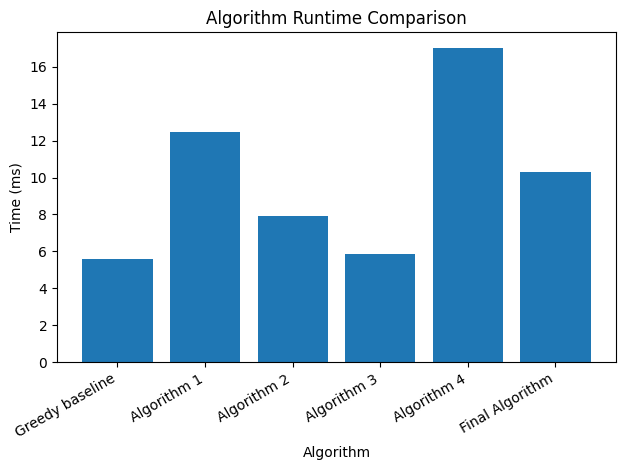

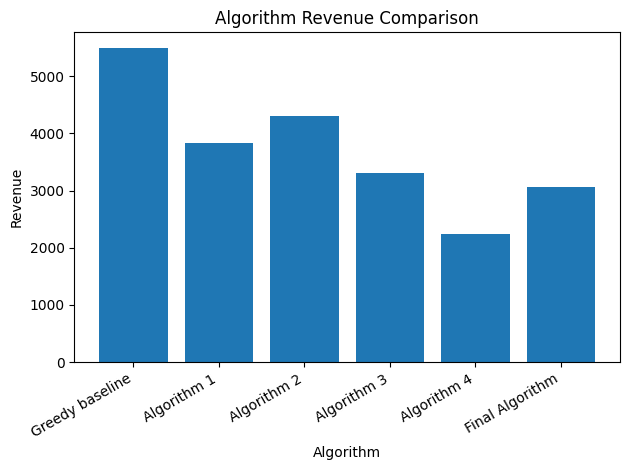

In [14]:
compare_algorithms(
    n = 10,
    stores_filepath="datasets/stores11.csv",
    customers_filepath="datasets/customers11.csv"
)


In [ ]:
# 0 demand --> actual waste from store
# 5 bags 1 customer --> customer gets all that food...not waste from tbs but waste from customer

def main():
    # here is where we run the simulation
    
    stores_filepath = "datasets/stores11.csv"    
    customers_filepath = "datasets/customers11.csv"  

    # data_reader returns lists of Store and Customer objects
    stores, customers = data_reader(stores_filepath = stores_filepath, customers_filepath = customers_filepath)
    marketplace = Marketplace(stores = stores, customers = customers)

    # basic_simulation(stores, customers)
    simulator = Simulator(stores = stores, customers = customers, marketplace = marketplace)

    try:
        simulator.simulate()
    except Exception as e:
        print(f"Error in simulator...: {e}")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error running program: {e}")


In [ ]:
def basic_simulation(stores, customers): # DEPRECATED !!! but still keep
    """
    basic simulation for milestone 2
    - uses Marketplace with the greedy baseline
    - at the end we compute KPIs from Marketplace
    """
    try:
        app = Marketplace(stores=stores, customers=customers)

        print("=== SIMULATION START ===\n")

        # each customer arrives, sees some stores, and reserves from one of them
        for customer in app.get_customers():
            # print(f"Customer {customer.get_customer_id()} views the following stores:")

            selected_stores = app.select(customer)

            # for i, store in enumerate(selected_stores, start=1):
            #     print(f"{i}: {store.get_store_name()}")

            # simulate a reservation choice
            if selected_stores:   # make sure list is not empty
                chosen_store = random.choice(selected_stores)

                if chosen_store.get_unreserved_bags() > 0:
                    chosen_store.reserve_bag()
                    customer.reserve(chosen_store.get_store_id())

            print()

        print("=== END OF DAY SUMMARY ===\n")
        for store in app.get_stores():
            print(f"{store.get_store_name()} | Reserved: {store._bags_reserved}/{store.get_estimated_bags()}")

        print("\nCustomer reservations:")
        for customer in app.get_customers():
            reserved_store = customer.get_reserved_store()
            if reserved_store is None:
                print(f"Customer {customer.get_customer_id()} FAILED to reserve a store")
            else:
                print(f"Customer {customer.get_customer_id()} reserved from store: {reserved_store}")


        kpis = app.compute_kpis()

        print("\n=== KPIs FOR GREEDY BASELINE (MILESTONE 2) ===")
        print(f"Total bags sold:          {kpis['total_bags_sold']}")
        print(f"Total bags unsold:        {kpis['total_bags_unsold']}")
        print(f"Total bags canceled:      {kpis['total_bags_canceled']}")
        print(f"Total revenue:            {kpis['total_revenue']:.2f}")
        print(f"Max possible revenue:     {kpis['max_possible_revenue']:.2f}")
        print(f"Revenue lost:             {kpis['revenue_lost']:.2f}")
        print(f"Cancellation rate:        {kpis['cancellation_rate']:.3f}")
        print(f"Food waste rate:          {kpis['food_waste_rate']:.3f}")
        print(f"Revenue efficiency:       {kpis['revenue_efficiency']:.3f}")
        print(f"Customers who left:       {kpis['customers_left']}")
        print(f"Fairness score (0–1):     {kpis['fairness_score']:.3f}")


        print("\n=== SIMULATION END ===")

    except Exception as e:
        print(f"Error Running Simulation: {e}")